In [1]:
import pandas as pd
import numpy as np

from scipy.fft import fft, fftfreq, ifft, fft2, ifft2, ifftshift
from scipy.signal import blackman
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift
from scipy.signal import butter
from scipy import signal
from scipy.signal import convolve2d as conv2

from skimage import color, data, restoration
from scipy.ndimage import gaussian_filter as gf

from xrdc import featurization as feat
from xrdc import fourier
from xrdc.datasets import d3d


#pd.options.plotting.backend = "matplotlib"
pd.options.plotting.backend = "plotly"

Loading Data from: /Users/ollie/Documents/SLAC/xrd_clustering/notebooks/../../TiNiSn_500C-20190604T152446Z-001/TiNiSn_500C/
Data Loaded Succesfully
(177, 800)


In [2]:
from xrdc import source_separation as sep
from xrdc import featurization as feat
from xrdc.datasets import d3d

from xrdc import peak_fitting as pf

from importlib import reload
reload(feat)

workflows/alanConfig


<module 'xrdc.featurization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py'>

In [3]:
def annotate():
    plt.xlabel('$q~(1 / A)$')
    plt.ylabel('sample index')

imargs = {'cmap': 'jet', 'aspect': 8}
aspect = 8

def heatmap(fig, arr, label = '', **kwargs):
    ax = fig

    stride = 100
    qticks = d3d.q[::stride]
    labels = ['{:0.1f}'.format(elt) for elt in qticks]
    
    ax.set_xticklabels(labels);
    ax.set_xticks(np.arange(len(qticks)) * stride);
    if kwargs is not None:
        (kwargs.update(imargs))
    else:
        kwargs = imargs
    plt.imshow(arr, **kwargs)
    plt.title(label)
    annotate()
    
def norm(arr):
    return arr / arr.mean()

In [4]:
df = pd.read_csv("YijinXRD.dat", sep = '\t')
qq = df.iloc[:, 0]

patterns = df.iloc[:, 2:]
patterns = (patterns.values.T)[:, 1:]

for i in range(len(patterns)):
    patterns[i] = patterns[i] - i * 1000
    
background_extra, _, _, _ = sep.separate_signal(patterns, background_after_filter = False,
                                                    threshold = 50, smooth_q = 1.7, bg_fill_method = 'simple',
                                                    smooth_q_background = 6)

# multiply normalized patterns by 1000 so that the peak-finding routine will play nice
patterns = m3d = 1000 * d3d.get_data().copy()[7, :, :]
#patterns = m3d_agglom# = m3d.reshape(15, 15, -1, 2).sum(axis = 3)

tmp = np.zeros_like(patterns)
tmp[:patterns.shape[0], :background_extra.shape[1]] = background_extra[:patterns.shape[0], :]
tmp = sep.CTinterpolation(tmp)

tmp *= (patterns.mean() / tmp.mean())

patterns = patterns + 2 * tmp

from xrdc import source_separation as sep
background, fast_q, slow_T, fast_T = sep.separate_signal(patterns, background_after_filter = True,
                                                    threshold = 50, smooth_q = 1.7, bg_fill_method = 'simple',
                                                    smooth_q_background = 6,
                                                    smooth_neighbor_background = 1)

import matplotlib
plt.rcParams["figure.figsize"]=(12, 12)
matplotlib.rcParams["figure.figsize"]=(12, 12)


%matplotlib inline
def annotate_axes(ax, text, fontsize=18):
    ax.text(0.5, 0.5, text, transform=ax.transAxes,
            ha="center", va="center", fontsize=fontsize, color="darkgrey")
    

(0, 0)
(0, 0)


Calculate heatmap for visualization of peak shift correction

In [ ]:
fsub_stop_2d = pf.curvefit_2d((patterns - 0), stdratio_threshold = 2, noise_estimate = fast_T,
                   background = background, bg_shift_pos = False)

patterns_pp = fast_q - fast_q.min()
patterns_pp /= patterns_pp.mean()
fitlists = fsub_stop_2d[1]
labeled, feature_masks, activations, norm_, activations_n1 = feat.peakfit_featurize(patterns_pp, fitlists,
                                                                    size_thresh = 3)

straightened_heatmap = feat.get_peakshift_corrected_heatmap(patterns, activations, labeled)

/Users/ollie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


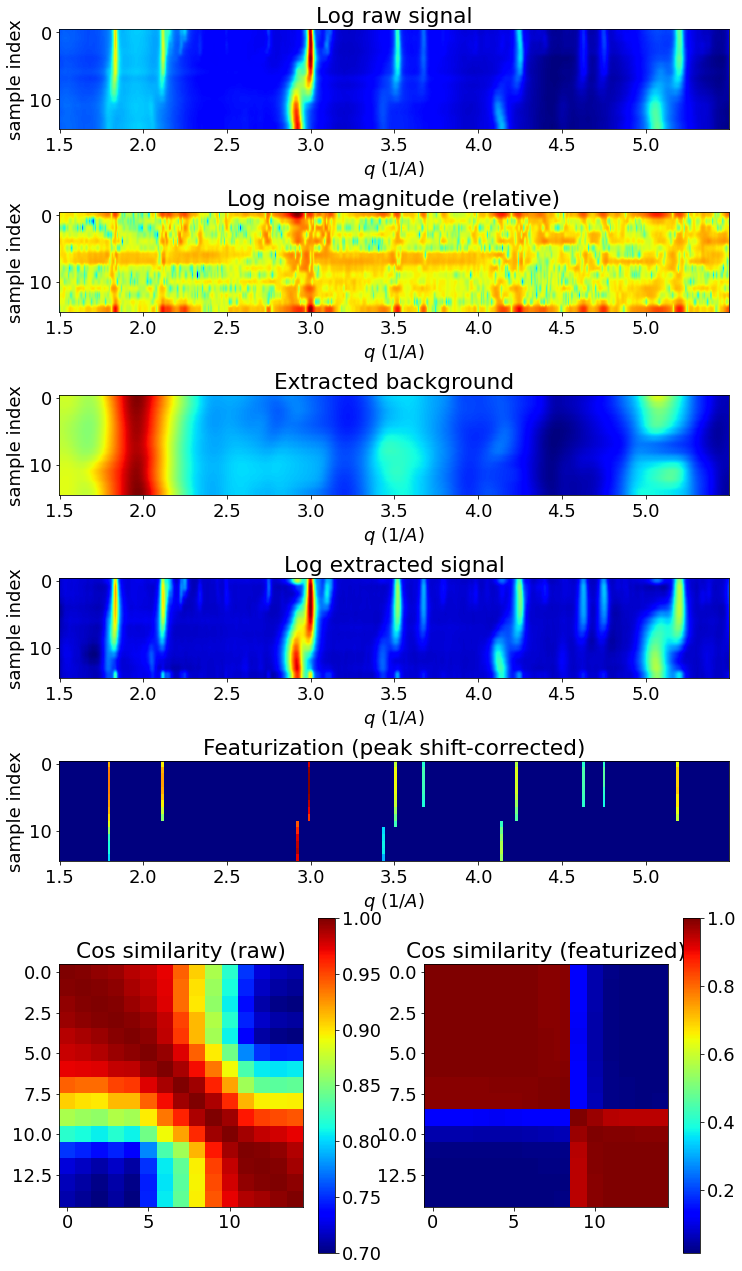

In [454]:
matplotlib.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(12, 23), constrained_layout=False)
spec = fig.add_gridspec(7, 2)

imargs = {'cmap': 'jet', 'aspect': 8}

ax0 = fig.add_subplot(spec[0, :])
heatmap(ax0, np.log(1 + norm(patterns)), label = 'Log raw signal')
# annotate_axes(ax0, 'ax0')

ax1 = fig.add_subplot(spec[1, :])
heatmap(ax1, np.log10(np.abs(fast_T / patterns) ), "Log noise magnitude (relative)")
#annotate_axes(ax10, 'ax10')


ax2 = fig.add_subplot(spec[2, :])
heatmap(ax2, background, 'Extracted background')
# plt.title("Log signal")

ax3 = fig.add_subplot(spec[3, :])
#heatmap(ax3, np.log(1 + norm(fast_q - fast_q.min())))
heatmap(ax3, np.log(1 + norm((slow_T - background) - (slow_T - background).min())), "Log extracted signal")
# annotate_axes(ax11, 'ax11')

ax4 = fig.add_subplot(spec[4, :])
heatmap(ax4, np.log(1 + straightened_heatmap), interpolation = 'none',
        label = 'Featurization (peak shift-corrected)')

imargs = {'cmap': 'jet', 'aspect': 1}

ax50 = fig.add_subplot(spec[5:7, 0])
img = ax50.imshow(feat.csim_pairs(patterns), cmap = 'jet')
plt.title('Cos similarity (raw)')
plt.colorbar(img, ax = ax50)

ax51 = fig.add_subplot(spec[5:7, 1])
img = ax51.imshow(feat.csim_pairs(activations.T), cmap = 'jet')
plt.title('Cos similarity (featurized)')
plt.colorbar(img, ax = ax51)

# fig.suptitle('Manually added subplots, spanning a column')

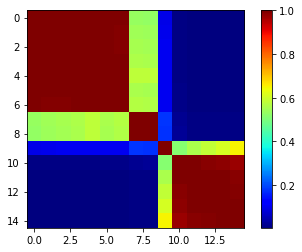

In [440]:
plt.imshow(feat.csim_pairs(activations_n1.T), cmap = 'jet')
plt.colorbar()

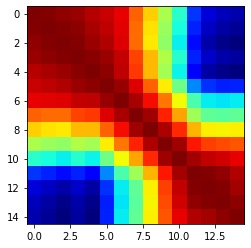

In [419]:
plt.imshow(feat.csim_pairs(patterns), cmap = 'jet')

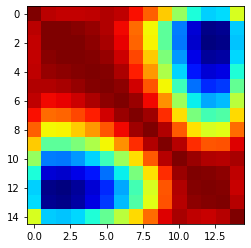

In [418]:
plt.imshow(feat.csim_pairs(((slow_T - background) - (slow_T - background).min())), cmap = 'jet')

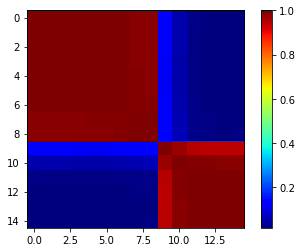

In [431]:
plt.imshow(feat.csim_pairs(activations.T), cmap = 'jet')
plt.colorbar()

In [435]:
feat.csim_pairs(activations.T).max()

1.0000000000000004

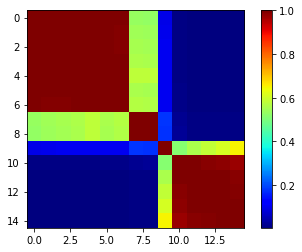

In [409]:
plt.imshow(feat.csim_pairs(activations_n1.T), cmap = 'jet')
plt.colorbar()

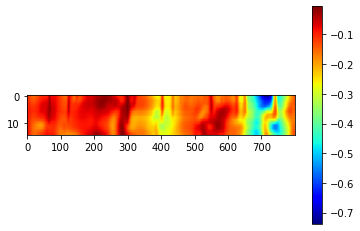

In [364]:
plt.imshow((2 * tmp - background) / patterns, cmap = 'jet', aspect = aspect)
plt.colorbar()

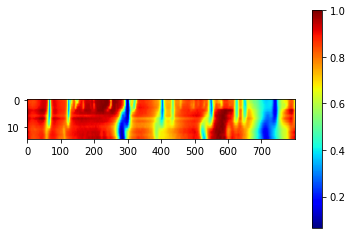

In [365]:
plt.imshow((2 * tmp) / patterns, cmap = 'jet', aspect = aspect)
plt.colorbar()

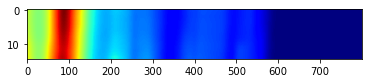

In [366]:
plt.imshow(tmp, cmap = 'jet', aspect = aspect)

/Users/ollie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


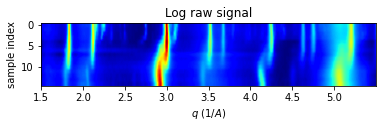

In [119]:
fig, ax = plt.subplots(1,1)
heatmap(fig, ax)

In [ ]:
plt.imshow(slow_q, cmap = 'jet')
plt.title("Interpolated background")
annotate()